In [1]:
import matplotlib.pyplot as plt
from matplotlib import collections as mc
import numpy as np
import pylab as pl
import sys
import xarray as xr
import yaml

### Global variables

In [12]:
yaml_file = './config.yaml'
params = yaml.safe_load(open(yaml_file))

INPUT_PATH_GRID = params['input_path_grid_nc']
INPUT_PATH_SSH = params['input_path_data_nc']
#PATH_PILOT_SSH = "../data/pilot/raw/pilot_ssh.nc"

LEFT = params['input_left']
RIGHT = params['input_right']
BOTTOM = params['input_bottom']
TOP = params['input_top']

OUTPUT_PATH_GRID_SUBSET = params['output_path_grid_subset']

# TODO: for every path in SSH, read the file and (delete the useless field)
# concatenate them, or read them with open_mfdataset()

### Read and print the mesh

In [3]:
data_mesh = xr.open_dataset(INPUT_PATH_GRID, engine='netcdf4')
data_mesh

<xarray.Dataset>
Dimensions:            (nz: 70, nz1: 69, elem: 17628297, nod2: 8852366, n3: 3,
                        n2: 2, N: 8, edg_n: 26481174, n4: 4)
Coordinates:
  * nz                 (nz) float64 0.0 -5.0 -10.0 ... -6e+03 -6.35e+03
  * nz1                (nz1) float64 -2.5 -7.5 -12.5 ... -5.825e+03 -6.175e+03
Dimensions without coordinates: elem, nod2, n3, n2, N, edg_n, n4
Data variables: (12/19)
    elem_area          (elem) float64 ...
    nlevels_nod2D      (nod2) int32 ...
    nlevels            (elem) int32 ...
    nod_in_elem2D_num  (nod2) int32 ...
    nod_part           (nod2) int32 ...
    elem_part          (elem) int32 ...
    ...                 ...
    nod_in_elem2D      (N, nod2) int32 ...
    edges              (n2, edg_n) int32 ...
    edge_tri           (n2, edg_n) int32 ...
    edge_cross_dxdy    (n4, edg_n) float64 ...
    gradient_sca_x     (elem, n3) float64 ...
    gradient_sca_y     (elem, n3) float64 ...

### Plot: entire world

Text(0, 0.5, 'Latitude')

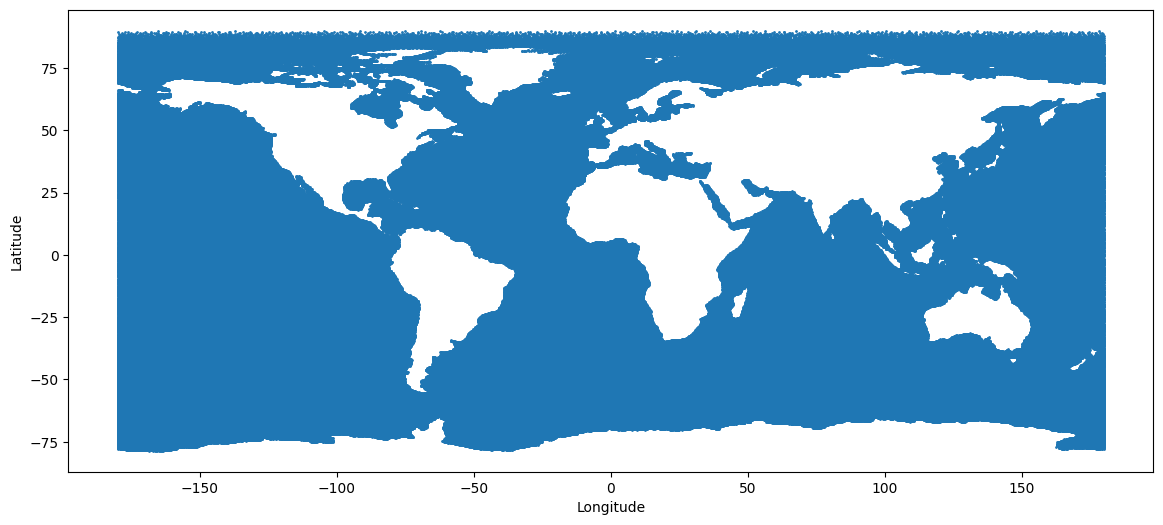

In [4]:
model_lon = data_mesh.lon.values
model_lat = data_mesh.lat.values

step = 10
plt.figure(figsize=(14, 6))
plt.scatter(model_lon[::step], model_lat[::step], s=1)
plt.xlabel('Longitude', size=10)
plt.ylabel('Latitude', size=10)

### Deletion of useless fields

In [5]:
vars_keys = data_mesh.data_vars
for key in vars_keys:
    if key != 'lat' and key != 'lon' and key != 'edges' and key != 'nodes':
        data_mesh = data_mesh.drop_vars(key)

data_mesh = data_mesh.drop_vars('nz')   # These 2 are coordinates, not variables
data_mesh = data_mesh.drop_vars('nz1')
data_mesh

<xarray.Dataset>
Dimensions:  (nod2: 8852366, n2: 2, edg_n: 26481174)
Dimensions without coordinates: nod2, n2, edg_n
Data variables:
    lon      (nod2) float64 -177.4 -177.2 -177.3 -177.3 ... 178.4 178.4 178.3
    lat      (nod2) float64 -78.05 -78.05 -78.08 -78.02 ... -77.85 -77.82 -77.85
    nodes    (n2, nod2) float64 ...
    edges    (n2, edg_n) int32 ...

### RoI & Plot: South Atlantic mask extraction (Eddy-rich region)

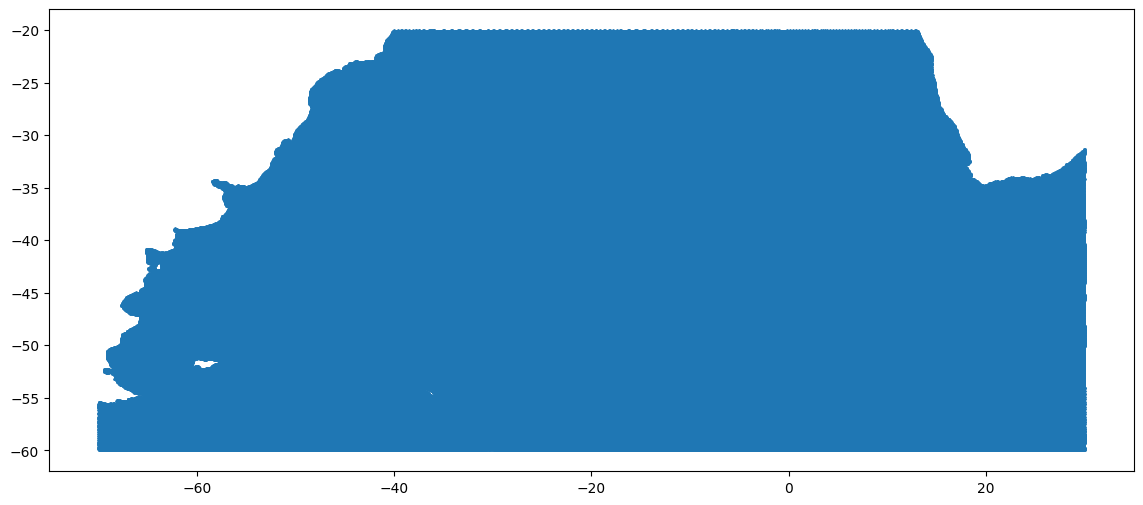

In [13]:
region_mask = (model_lon > LEFT) & (model_lon < RIGHT) & (model_lat < TOP) & (model_lat > BOTTOM)

step = 1
plt.figure(figsize=(14, 6))
plt.scatter(model_lon[region_mask][::step], model_lat[region_mask][::step], s=1)

### RoI: edges extraction

In [7]:
# Decrease by 1 since for compatibility with Fortran the indexes start from 1 instead of 0
edge_0 = data_mesh.edges[0].values
edge_1 = data_mesh.edges[1].values
edge_0 -= 1
edge_1 -= 1

edges_subset = []
for i in range(len(edge_0)):
    if region_mask[edge_0[i]] & region_mask[edge_1[i]]:
        edges_subset.append([edge_0[i], edge_1[i]])

edges_subset = np.array(edges_subset, dtype="int32")
data_mesh = data_mesh.drop_vars('edges')
data_mesh['edges'] = (('edges_subset', 'n2'), edges_subset)
data_mesh

<xarray.Dataset>
Dimensions:  (nod2: 8852366, n2: 2, edges_subset: 2268763)
Dimensions without coordinates: nod2, n2, edges_subset
Data variables:
    lon      (nod2) float64 -177.4 -177.2 -177.3 -177.3 ... 178.4 178.4 178.3
    lat      (nod2) float64 -78.05 -78.05 -78.08 -78.02 ... -77.85 -77.82 -77.85
    nodes    (n2, nod2) float64 ...
    edges    (edges_subset, n2) int32 1035320 1035378 ... 7106912 7106914

### RoI: nodes extraction

In [8]:
nodes_subset = []
for i in range(len(region_mask)):
    if region_mask[i]:
        nodes_subset.append(i)

nodes_subset = np.array(nodes_subset, dtype="int32")
data_mesh['nodes'] =(('nodes_subset'), nodes_subset)
data_mesh

<xarray.Dataset>
Dimensions:  (nod2: 8852366, nodes_subset: 757747, edges_subset: 2268763, n2: 2)
Dimensions without coordinates: nod2, nodes_subset, edges_subset, n2
Data variables:
    lon      (nod2) float64 -177.4 -177.2 -177.3 -177.3 ... 178.4 178.4 178.3
    lat      (nod2) float64 -78.05 -78.05 -78.08 -78.02 ... -77.85 -77.82 -77.85
    nodes    (nodes_subset) int32 1035320 1035324 1035345 ... 7853535 7853537
    edges    (edges_subset, n2) int32 1035320 1035378 ... 7106912 7106914

### Plot: final RoI

Text(0, 0.5, 'Latitude')

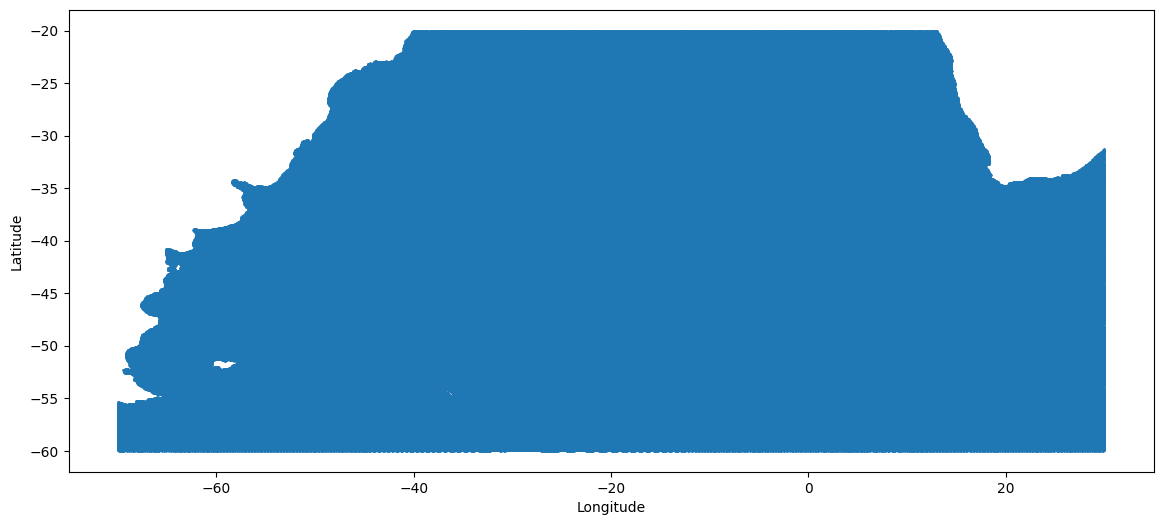

In [9]:
model_lon_roi = data_mesh.lon[data_mesh.nodes].values
model_lat_roi = data_mesh.lat[data_mesh.nodes].values

step = 1
plt.figure(figsize=(14, 6))
plt.scatter(model_lon_roi[::step], model_lat_roi[::step], s=1)
plt.xlabel('Longitude', size=10)
plt.ylabel('Latitude', size=10)

### Plot: just the connections of the RoI
##### (If everything is green is because the selected area is dense with edges)

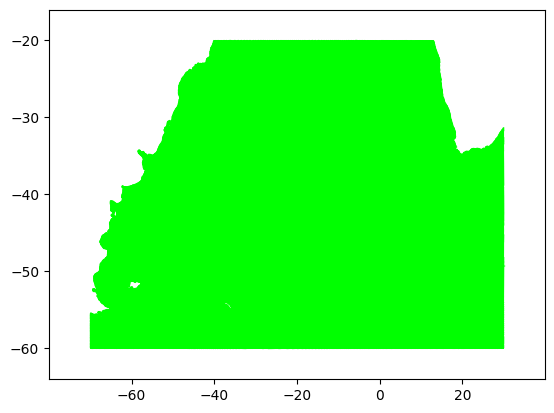

In [10]:
edge_0 = data_mesh.edges[:, 0].values
edge_1 = data_mesh.edges[:, 1].values
x_0 = []
y_0 = []
x_1 = []
y_1 = []
for i in range(edge_0.size):
    if region_mask[edge_0[i]] & region_mask[edge_1[i]]:
        # First the connection starting points
        x_0.append(float(model_lon[edge_0[i]]))
        y_0.append(float(model_lat[edge_0[i]]))
        # Then the connection end points
        x_1.append(float(model_lon[edge_1[i]]))
        y_1.append(float(model_lat[edge_1[i]]))

# Organizing the start and ending connection points for visualization
lines = []
for i in range(len(x_0)):
    lines.append([(x_0[i], y_0[i]), (x_1[i], y_1[i])])

# Color mask to green
c = [(0, 1, 0, 1)]*len(x_0)

lc = mc.LineCollection(lines, colors=c, linewidths=1)
fig, ax = pl.subplots()
ax.add_collection(lc)
ax.margins(0.1)
plt.show()

### Save the subset mesh

In [11]:
data_mesh.to_netcdf(OUTPUT_PATH_GRID_SUBSET, engine='netcdf4')